In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.feature import ChiSqSelector, UnivariateFeatureSelector
from pyspark.ml.feature import VarianceThresholdSelector
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

Matplotlib created a temporary cache directory at /tmp/matplotlib-eyjkp45m because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "4g") \
    .config('spark.executor.instances', 4) \
    .appName("Steam Reviews") \
    .getOrCreate()

In [3]:
# Note that the file pay may need to be updated depending on csv file location
# Full file path could be something like "/expanse/lustre/projects/uci150/USERNAME/kaggle/all_reviews.csv" with USERNAME replaced appropriately
Steam_data = sc.read.csv("kaggle/all_reviews.csv",header=True, inferSchema=True)

# Data pre-processing

In [4]:
# Review data types imported
Steam_data.dtypes

[('recommendationid', 'string'),
 ('appid', 'string'),
 ('game', 'string'),
 ('author_steamid', 'string'),
 ('author_num_games_owned', 'string'),
 ('author_num_reviews', 'string'),
 ('author_playtime_forever', 'string'),
 ('author_playtime_last_two_weeks', 'string'),
 ('author_playtime_at_review', 'string'),
 ('author_last_played', 'string'),
 ('language', 'string'),
 ('review', 'string'),
 ('timestamp_created', 'string'),
 ('timestamp_updated', 'string'),
 ('voted_up', 'string'),
 ('votes_up', 'string'),
 ('votes_funny', 'string'),
 ('weighted_vote_score', 'string'),
 ('comment_count', 'string'),
 ('steam_purchase', 'string'),
 ('received_for_free', 'string'),
 ('written_during_early_access', 'string'),
 ('hidden_in_steam_china', 'string'),
 ('steam_china_location', 'string')]

In [5]:
# Specify list of correct data types for each column
types = [('recommendationid', 'bigint'),
 ('appid', 'bigint'),
 ('game', 'string'),
 ('author_steamid', 'bigint'),
 ('author_num_games_owned', 'int'),
 ('author_num_reviews', 'int'),
 ('author_playtime_forever', 'double'),
 ('author_playtime_last_two_weeks', 'double'),
 ('author_playtime_at_review', 'int'),
 ('author_last_played', 'int'),
 ('language', 'string'),
 ('review', 'string'),
 ('timestamp_created', 'string'),
 ('timestamp_updated', 'string'),
 ('voted_up', 'float'),
 ('votes_up', 'int'),
 ('votes_funny', 'int'),
 ('weighted_vote_score', 'float'),
 ('comment_count', 'int'),
 ('steam_purchase', 'boolean'),
 ('received_for_free', 'boolean'),
 ('written_during_early_access', 'boolean'),
 ('hidden_in_steam_china', 'boolean'),
 ('steam_china_location', 'string')]

In [6]:
# Correct any incorrectly imported types to their correct type
for pair in types:
    column_name = pair[0]
    data_type = pair[1]
    Steam_data = Steam_data.withColumn(column_name, col(column_name).cast(data_type))

In [7]:
# Some pre-filtering steps
Steam_data = Steam_data.filter(Steam_data.language == 'english') ## English Only Reviews, don't have to do this if we are not looking at text data. Should do this for NLP
Steam_data = Steam_data.filter((Steam_data.voted_up == '0') | (Steam_data.voted_up == '1')) ## There's reviews in some of these

In [8]:
## Selecting only studied columns, limiting columns
Select_Steam = Steam_data.select(
    'author_playtime_forever',
    'author_playtime_at_review',
    'author_playtime_last_two_weeks',
    'voted_up'
).cache()

In [9]:
# Filter out rows with nulls
col_list = list(Select_Steam.columns)
Select_Steam = Select_Steam.na.drop(subset=col_list)

Select_Steam.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in Select_Steam.columns]).show()

+-----------------------+-------------------------+------------------------------+--------+
|author_playtime_forever|author_playtime_at_review|author_playtime_last_two_weeks|voted_up|
+-----------------------+-------------------------+------------------------------+--------+
|                      0|                        0|                             0|       0|
+-----------------------+-------------------------+------------------------------+--------+



In [10]:
# Generate dataframe for pyspark machine learning
assembler = VectorAssembler(inputCols=Select_Steam.columns[:3], outputCol="features", handleInvalid='skip')
df = assembler.transform(Select_Steam)

# Initial Model Fitting

In [11]:
# Establishing variable, train/test data sets, and fitting logistic regression model
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

log_reg = LogisticRegression(featuresCol="features", labelCol="voted_up")

log_reg_model = log_reg.fit(train_data)
param = [0.01, 0.1, 1, 10, 100]

In [12]:
# Generating data to plot logloss for train/test sets
train_error=[]
test_error=[]

evaluator = MulticlassClassificationEvaluator(labelCol='voted_up', predictionCol='prediction', metricName='logLoss')

for i in param:
    log_reg = LogisticRegression(featuresCol="features", labelCol="voted_up", regParam=1/i)
    log_reg_model = log_reg.fit(train_data)
    test_predictions = log_reg_model.transform(test_data)
    train_predictions = log_reg_model.transform(train_data)
    test_errors=evaluator.evaluate(test_predictions)
    train_errors=evaluator.evaluate(train_predictions)
    test_error.append(test_errors)
    train_error.append(train_errors)

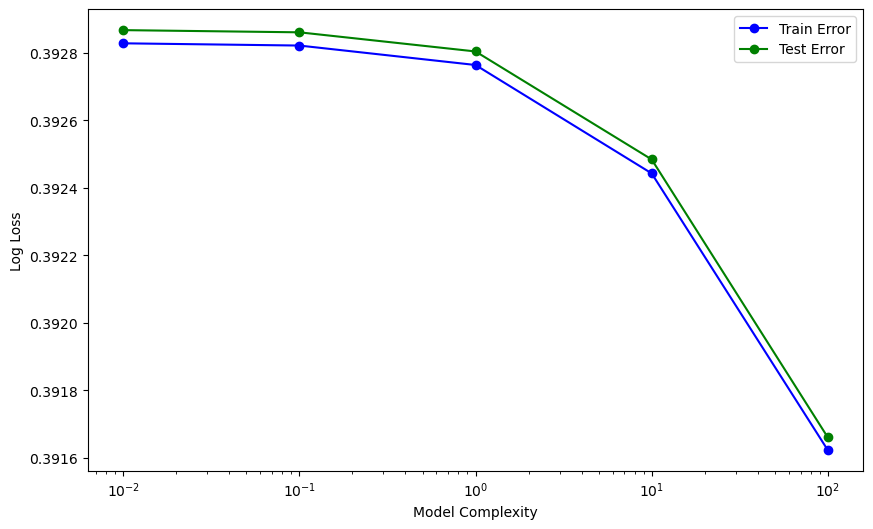

In [13]:
plt.figure(figsize=(10,6))
plt.plot(param, train_error, label="Train Error", color='blue', marker='o')
plt.plot(param, test_error, label="Test Error", color='green', marker='o')
plt.xlabel("Model Complexity")
plt.ylabel("Log Loss")
plt.legend()
plt.xscale('log')

In [14]:
# Generating data to plot accuracy for train/test sets
train_error=[]
test_error=[]

evaluator = MulticlassClassificationEvaluator(labelCol='voted_up', predictionCol='prediction', metricName='accuracy')

for reg_param in param:
    log_reg = LogisticRegression(featuresCol="features", labelCol="voted_up", regParam=1/reg_param)
    log_reg_model = log_reg.fit(train_data)
    test_predictions = log_reg_model.transform(test_data)
    train_predictions = log_reg_model.transform(train_data)
    
    train_acc = evaluator.evaluate(train_predictions)
    test_acc = evaluator.evaluate(test_predictions)
    train_errors=1-train_acc
    test_errors=1-test_acc
    
    test_error.append(test_errors)
    train_error.append(train_errors)

In [15]:
train_error

[0.1334158581698872,
 0.1334158581698872,
 0.1334158581698872,
 0.1334158581698872,
 0.13341851934355675]

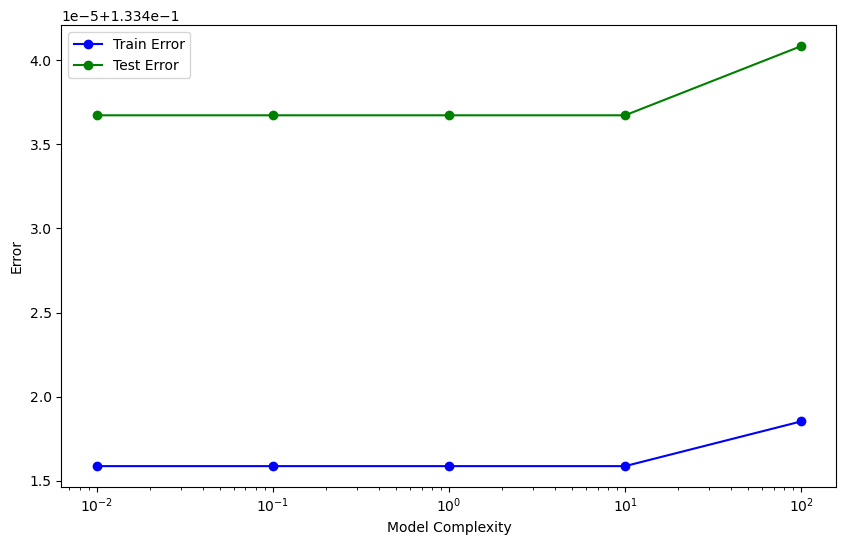

In [16]:
plt.figure(figsize=(10,6))
plt.plot(param, train_error, label="Train Error", color='blue', marker='o')
plt.plot(param, test_error, label="Test Error", color='green', marker='o')
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.legend()
plt.xticks(param)
plt.xscale('log')

# Next Steps
The code blocks that follow contain some feature selection methods to begin exploring potential updates to our model.

In [17]:
## Selecting only studied columns, limiting columns
Select_Steam_fselect = Steam_data.select(
    'author_playtime_forever',
    'author_playtime_at_review',
    'author_playtime_last_two_weeks',
    'author_num_games_owned',
    'author_num_reviews',
    'voted_up'
).cache()

In [18]:
Select_Steam_fselect = Select_Steam_fselect.withColumn('voted_up', Select_Steam_fselect['voted_up'].cast('float'))
#Select_Steam_fselect = Select_Steam_fselect.withColumn('written_during_early_access', Select_Steam_fselect['written_during_early_access'].cast('float'))

In [19]:
assembler = VectorAssembler(inputCols=Select_Steam_fselect.columns[:5], outputCol="features", handleInvalid='skip')
df = assembler.transform(Select_Steam_fselect)

In [20]:
df = df.select('features', 'voted_up').withColumnRenamed('voted_up', 'label')
df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[197.0,197.0,41.0...|  1.0|
|[12107.0,12107.0,...|  1.0|
|[42519.0,42515.0,...|  1.0|
|[30.0,30.0,0.0,71...|  1.0|
|[209.0,209.0,200....|  1.0|
+--------------------+-----+
only showing top 5 rows



In [21]:
assembler = VectorAssembler(inputCols=Select_Steam_fselect.columns[:6], outputCol="features", handleInvalid='skip')
df_all = assembler.transform(Select_Steam_fselect)
df_all.show(5)

+-----------------------+-------------------------+------------------------------+----------------------+------------------+--------+--------------------+
|author_playtime_forever|author_playtime_at_review|author_playtime_last_two_weeks|author_num_games_owned|author_num_reviews|voted_up|            features|
+-----------------------+-------------------------+------------------------------+----------------------+------------------+--------+--------------------+
|                  197.0|                      197|                          41.0|                     0|                 2|     1.0|[197.0,197.0,41.0...|
|                12107.0|                    12107|                           0.0|                    69|                 1|     1.0|[12107.0,12107.0,...|
|                42519.0|                    42515|                           3.0|                     0|                 5|     1.0|[42519.0,42515.0,...|
|                   30.0|                       30|                   

In [22]:
df_all = df_all.select('features')

In [23]:

r1 = Correlation.corr(df_all, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[ 1.        ,  0.7886514 ,  0.34475927, -0.0321441 , -0.03143936,
               0.0222244 ],
             [ 0.7886514 ,  1.        ,  0.20948163, -0.02643021, -0.02726179,
              -0.00461497],
             [ 0.34475927,  0.20948163,  1.        , -0.01921135, -0.01409563,
               0.01132714],
             [-0.0321441 , -0.02643021, -0.01921135,  1.        ,  0.27862913,
              -0.03877855],
             [-0.03143936, -0.02726179, -0.01409563,  0.27862913,  1.        ,
              -0.03944351],
             [ 0.0222244 , -0.00461497,  0.01132714, -0.03877855, -0.03944351,
               1.        ]])


# Decision Tree

In [28]:
from pyspark.ml.classification import DecisionTreeClassifier

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

dec_tree=DecisionTreeClassifier(featuresCol="features", labelCol="label")

decision_tree=dec_tree.fit(train_data)

In [30]:
predict=decision_tree.transform(test_data)
predict.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       1.0|[0.26572548090560...|
|  1.0|       0.0|[0.50014459061469...|
|  1.0|       0.0|[0.50014459061469...|
|  0.0|       0.0|[0.50014459061469...|
|  1.0|       1.0|[0.37475817215444...|
|  1.0|       1.0|[0.37475817215444...|
|  0.0|       1.0|[0.28822347986517...|
|  1.0|       1.0|[0.28822347986517...|
|  1.0|       1.0|[0.10488626259555...|
|  1.0|       1.0|[0.10488626259555...|
|  1.0|       1.0|[0.10488626259555...|
|  1.0|       1.0|[0.10488626259555...|
|  0.0|       1.0|[0.10488626259555...|
|  1.0|       1.0|[0.10488626259555...|
|  1.0|       1.0|[0.10488626259555...|
|  1.0|       1.0|[0.10488626259555...|
|  1.0|       1.0|[0.10488626259555...|
|  1.0|       1.0|[0.10488626259555...|
|  1.0|       1.0|[0.10488626259555...|
|  1.0|       1.0|[0.10488626259555...|
+-----+----------+--------------------+
only showing top 20 rows



In [31]:
evaluate=MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction", metricName="accuracy")
accuracy = evaluate.evaluate(predict)
accuracy

0.8666518258922112

In [32]:
predict.groupBy("label", "prediction").count().show()

+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|  1.0|       0.0|  77119|
|  0.0|       0.0|  78019|
|  1.0|       1.0|8553009|
|  0.0|       1.0|1250902|
+-----+----------+-------+

